In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

# Function for scores
def score_model(model, X_train, X_test, y_train, y_test):
    print(f'R2 of training: {r2_score(y_train,model.predict(X_train))}')
    print(f'R2 of test: {r2_score(y_test,model.predict(X_test))}')

    fig, ax = plt.subplots(figsize = (16,10))

    ax.scatter(y_test,model.predict(X_test))
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()

In [3]:
def getPipe(model, numerical_columns):
    """
    Prepares a pipe that 
        First:  Prepare the data prior to modelling. That is all numerical features 
                is standardized, all categotical are one.hot-encodeded. The features
                not specified as numerical or categorical are dropped if not specified.
        Second: Send the prepared data into the model.

    """
    # Pipeline to handle continous parameters. Here the parameters are scaled.
    # This is important to do each time so test data is not considered for 
    # normalization which would be the case if all data were standardized at once.
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns)
        ],
        remainder='passthrough'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe

def cv(pipe, parameters, X_train, y_train, cf = 5):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='neg_mean_squared_error', # Use MSE
        n_jobs=-1,
        return_train_score=True,
        verbose=1, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

## No zone and only local info

In [4]:
df = df_full.drop(columns=['index', 'hour_index', 'degree', 'dist_to_station']+weather_var, inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,30,0,1.000000,0.000364,0,0,1,0
1,86,0,0.999999,0.001018,0,0,1,0
2,4,0,0.999997,0.002327,1,0,0,0
3,30,0,0.999968,0.007999,0,0,1,0
4,32,0,0.999957,0.009236,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0
326588,59,0,0.999970,-0.007708,1,0,0,0
326589,48,0,0.999980,-0.006327,1,0,0,0
326590,23,0,0.999990,-0.004363,0,0,1,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [6]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel','Time_Cos','Time_Sin']

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ......, score=(train=-19.286, test=-19.208) total time=   0.1s
[CV 2/5; 1/1] END ......, score=(train=-19.272, test=-19.262) total time=   0.1s
[CV 1/5; 1/1] END ......, score=(train=-19.160, test=-19.713) total time=   0.1s
[CV 4/5; 1/1] END ......, score=(train=-19.336, test=-19.007) total time=   0.1s
[CV 3/5; 1/1] END ......, score=(train=-19.297, test=-19.165) total time=   0.1s


R2 of training: 0.09384310653845707
R2 of test: 0.09473135373075348


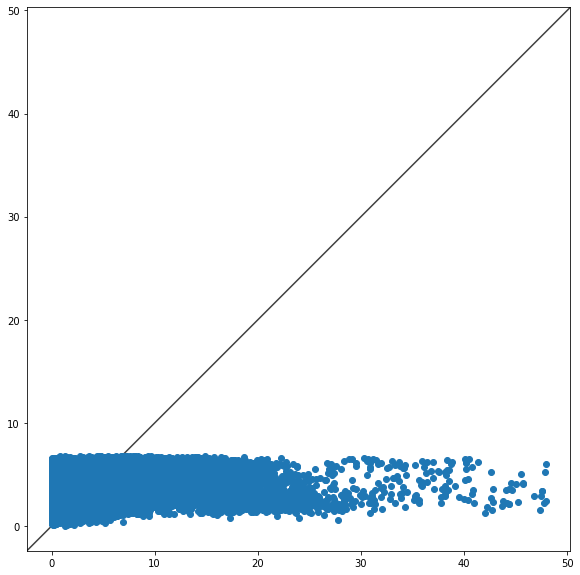

In [7]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [12]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel','Time_Cos','Time_Sin']

parameters = {
    'model__alpha': np.logspace(-3,-0.5,10),
    'model__l1_ratio': [0.001,0.01,0.1,0.5,0.9,1]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 2/5; 1/60] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 3/5; 1/60] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 4/5; 1/60] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 5/5; 1/60] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 1/5; 2/60] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 2/5; 2/60] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 3/5; 2/60] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 1/5; 2/60] END model__alpha=0.001, model__l1_ratio=0.01;, score=(train=-19.160, test=-19.713) total time=  13.7s
[CV 4/5; 2/60] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 2/5; 2/60] END model__alpha=0.001, model__l1_ratio=0.01;, score=(train=-19.272, test=-19

In [16]:
list(zip(elastic_net_cv.cv_results_['param_model__l1_ratio'],elastic_net_cv.cv_results_['mean_test_score']))

[(0.001, -19.2710395313514),
 (0.01, -19.271039816662178),
 (0.1, -19.2710399901629),
 (0.5, -19.27105052071189),
 (0.9, -19.27106611491793),
 (1, -19.271070099899084),
 (0.001, -19.271075773114735),
 (0.01, -19.271076722858616),
 (0.1, -19.27108021363541),
 (0.5, -19.271114305380852),
 (0.9, -19.27116629243282),
 (1, -19.271180671986635),
 (0.001, -19.271205467351457),
 (0.01, -19.27120866725877),
 (0.1, -19.271225275011833),
 (0.5, -19.271343395259716),
 (0.9, -19.271524809291453),
 (1, -19.271579730712865),
 (0.001, -19.271637827176956),
 (0.01, -19.271646625860406),
 (0.1, -19.271709697757373),
 (0.5, -19.272136840998407),
 (0.9, -19.272807856136346),
 (1, -19.273017064407526),
 (0.001, -19.27295845533713),
 (0.01, -19.272977860545822),
 (0.1, -19.273206334450514),
 (0.5, -19.274762940856615),
 (0.9, -19.277351944229668),
 (1, -19.27818862315551),
 (0.001, -19.27657406588238),
 (0.01, -19.27664148553238),
 (0.1, -19.27739657056899),
 (0.5, -19.282908501005316),
 (0.9, -19.293193307

alpha = 0.001, l1-ratio: 0.001
R2 of training: 0.09384234676871661
R2 of test: 0.09472880432373398


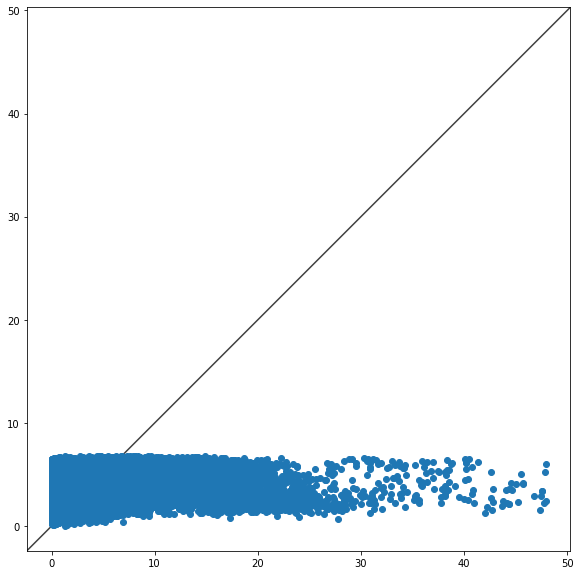

In [13]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [ ]:
RF_model = RandomForestRegressor()
numerical_columns = ['leave_fuel', 'Time_Cos','Time_Sin']

parameters = {
    'model__n_estimators': [50,100,200],
    'model__min_samples_leaf': [5,10,20]
}

RF_pipe = getPipe(
    model = RF_model,
    numerical_columns = numerical_columns,
)
RF_cv = cv(RF_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 4/5; 1/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50
[CV 1/5; 1/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50
[CV 1/5; 2/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=100
[CV 2/5; 1/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50
[CV 3/5; 1/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50
[CV 5/5; 1/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50
[CV 2/5; 2/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=100
[CV 3/5; 2/27] START model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=100
[CV 4/5; 1/27] END model__max_depth=5, model__min_samples_leaf=5, model__n_estimators=50;, score=(train=-18.677, test=-18.705) total time=  22.8s
[CV 1/5; 1/27] END model__max_depth=5, model__min_samples_lea

n_estimators = 200 min_samples_leaf = 10
R2 of training: 0.12718569522289858
R2 of test: 0.1229022746824332


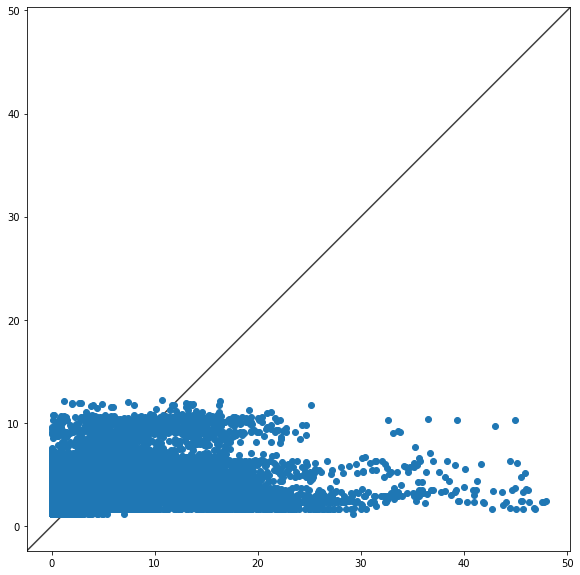

In [ ]:
best_idx = RF_cv.cv_results_['mean_test_score'].argmax()
n_estimators = RF_cv.cv_results_['param_model__n_estimators'].data[best_idx]
min_samples_leaf = RF_cv.cv_results_['param_model__min_samples_leaf'].data[best_idx]
#max_depth = RF_cv.cv_results_['param_model__max_depth'].data[best_idx]

print(f'n_estimators = {n_estimators}', f'min_samples_leaf = {min_samples_leaf}')#, f'max_depth = {max_depth}')

score_model(RF_cv, X_train, X_test, y_train, y_test)

In [ ]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel','Time_Cos','Time_Sin']

parameters = {
    'model__n_neighbors': [50,100,150],
    'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 2/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 3/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 4/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 5/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 1/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 2/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 3/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 1/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-18.343, test=-18.750) total time=  15.3s
[CV 4/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 2/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-18.209, te

n_neighbors = 150 weights = uniform
R2 of training: 0.1269843134874581
R2 of test: 0.11502917460238482


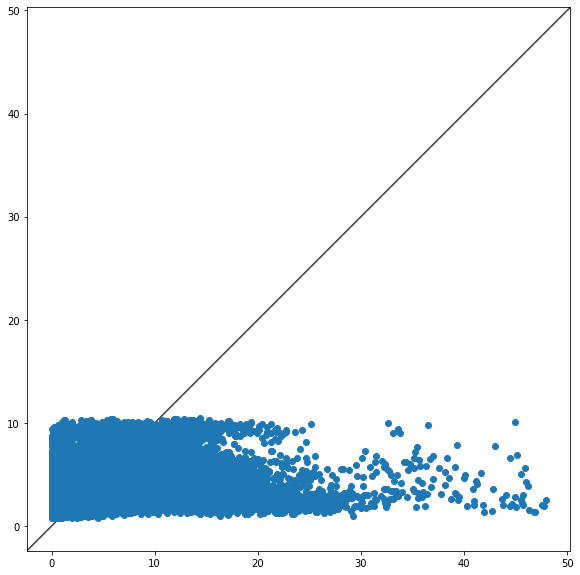

In [ ]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]

print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

## Add non-local info

In [24]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var, inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,495.570805


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [26]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'Time_Cos','Time_Sin','degree', 'dist_to_station']

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ......, score=(train=-18.901, test=-18.419) total time=   0.1s
[CV 2/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ......, score=(train=-18.714, test=-19.167) total time=   0.1s
[CV 3/5; 1/1] END ......, score=(train=-18.878, test=-18.510) total time=   0.1s
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 4/5; 1/1] END ......, score=(train=-18.747, test=-19.037) total time=   0.1s
[CV 5/5; 1/1] END ......, score=(train=-18.781, test=-18.899) total time=   0.1s


R2 of training: 0.11711689124153968
R2 of test: 0.11583371881232696


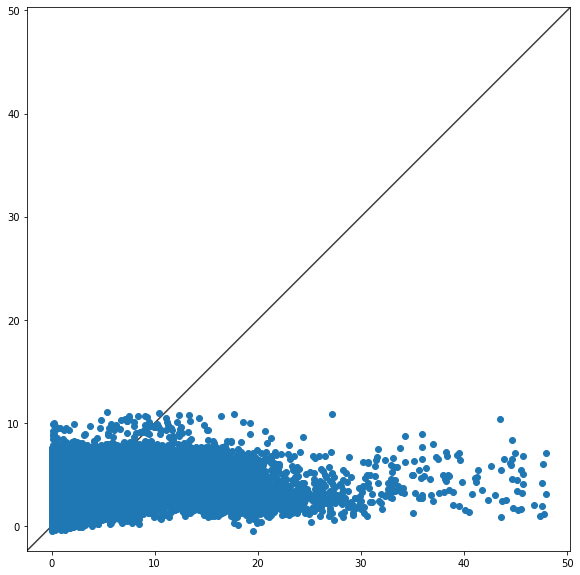

In [27]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [37]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'Time_Cos','Time_Sin','degree', 'dist_to_station']

parameters = {
    'model__alpha': np.logspace(-2, -0.5, 10),
    'model__l1_ratio': [0.01,0.05,0.1,0.2]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................[CV 3/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 5/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 4/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................

[CV 3/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 2/5; 2/40] END model__alpha=0.01, model__l1_ratio=0.05;, score=(train=-18.865, test=-18.408) total time=   1.3s
[CV 3/5; 2/40] END model__alpha=0.01, model__l1_ratio=0.05;, score=(train=-18.743, test=-18.894) total time=   1.5s
[CV 4/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.11685810630294813
R2 of test: 0.12068340722636794


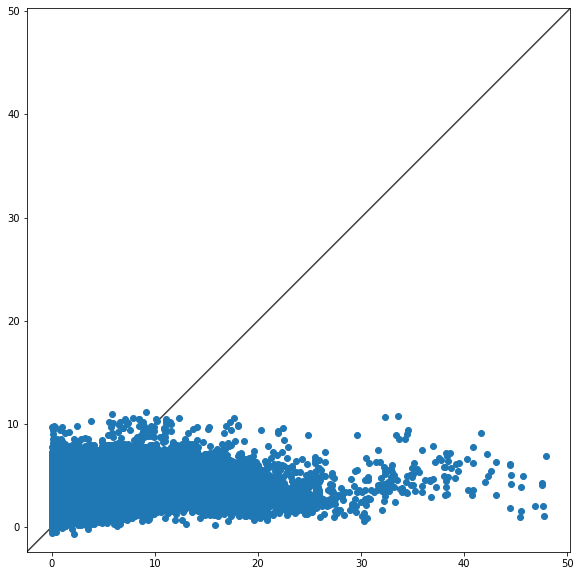

In [38]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [ ]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Time_Cos','Time_Sin']

parameters = {
    'model__n_neighbors': [50,100,150],
    'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 2/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 3/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 4/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 5/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 1/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 2/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 3/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 1/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-17.666, test=-18.320) total time=  25.2s
[CV 5/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-17.758, test=-17.951) total time=  25.9s
[CV 2/5; 1/6] END model__n_neighbors=50, model__we

n_neighbors = 150 weights = distance
R2 of training: 1.0
R2 of test: 0.15137502248041135


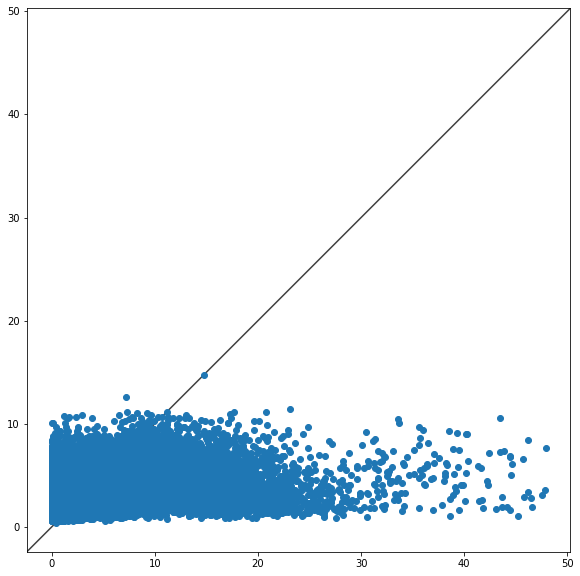

In [ ]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]
 
print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

## Add weather

In [43]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [44]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [45]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Time_Cos','Time_Sin']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ......, score=(train=-18.644, test=-18.863) total time=   0.3s
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ......, score=(train=-18.703, test=-18.625) total time=   0.3s
[CV 3/5; 1/1] END ......, score=(train=-18.641, test=-18.875) total time=   0.3s
[CV 4/5; 1/1] END ......, score=(train=-18.777, test=-18.332) total time=   0.3s
[CV 5/5; 1/1] END ......, score=(train=-18.670, test=-18.756) total time=   0.3s


R2 of training: 0.11686504546444587
R2 of test: 0.12102613093093084


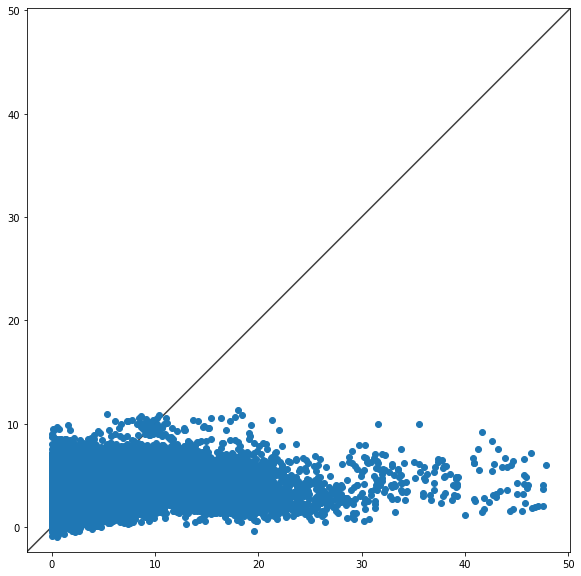

In [46]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [47]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Time_Cos','Time_Sin']+weather_var[:7]

parameters = {
    'model__alpha': np.logspace(-2, -0.5, 10),
    'model__l1_ratio': [0.01,0.05,0.1,0.2]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 4/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 5/5; 1/40] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 2/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 3/5; 2/40] START model__alpha=0.01, model__l1_ratio=0.05....................
[CV 1/5; 1/40] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-18.645, test=-18.862) total time=   2.1s
[CV 2/5; 2/40] END model__alpha=0.01, model__l1_ratio=0.05;, score=(train=-18.705, test=-18.625) total time=   1.5s
[CV 3/5; 2/40] END model__alpha=0.01, model__l1_ratio=0.05

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.1167962103222615
R2 of test: 0.12089324063334561


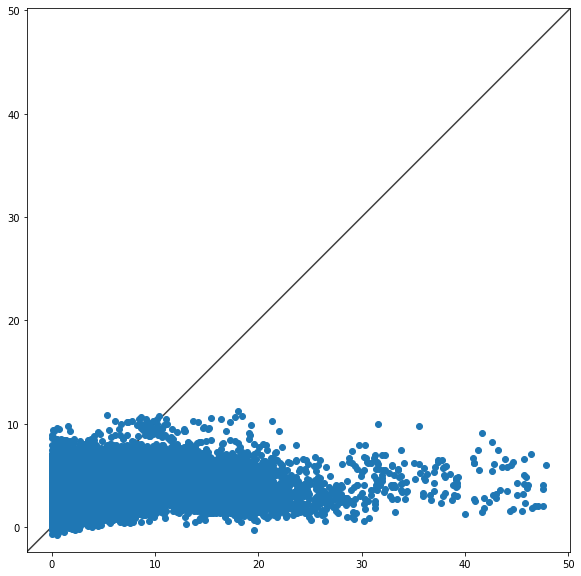

In [48]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [ ]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {
    'model__n_neighbors': [100,150]
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 2/5; 1/2] START model__n_neighbors=100......................................
[CV 1/5; 1/2] START model__n_neighbors=100......................................
[CV 3/5; 1/2] START model__n_neighbors=100......................................
[CV 4/5; 1/2] START model__n_neighbors=100......................................
[CV 5/5; 1/2] START model__n_neighbors=100......................................
[CV 1/5; 2/2] START model__n_neighbors=150......................................
[CV 2/5; 2/2] START model__n_neighbors=150......................................
[CV 3/5; 2/2] START model__n_neighbors=150......................................
[CV 4/5; 2/2] START model__n_neighbors=150......................................
[CV 5/5; 2/2] START model__n_neighbors=150......................................


KeyboardInterrupt: 

In [ ]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
#weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]

#print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

## Add zone

In [53]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [55]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station', 'Time_Cos', 'Time_Sin']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ......, score=(train=-17.088, test=-17.009) total time=  18.2s
[CV 2/5; 1/1] END ......, score=(train=-17.040, test=-17.194) total time=  18.2s
[CV 3/5; 1/1] END ......, score=(train=-17.014, test=-17.305) total time=  19.2s
[CV 4/5; 1/1] END ......, score=(train=-17.078, test=-17.045) total time=  19.2s
[CV 5/5; 1/1] END ......, score=(train=-17.082, test=-17.036) total time=  20.4s


R2 of training: 0.19639611341595298
R2 of test: 0.19608182593479562


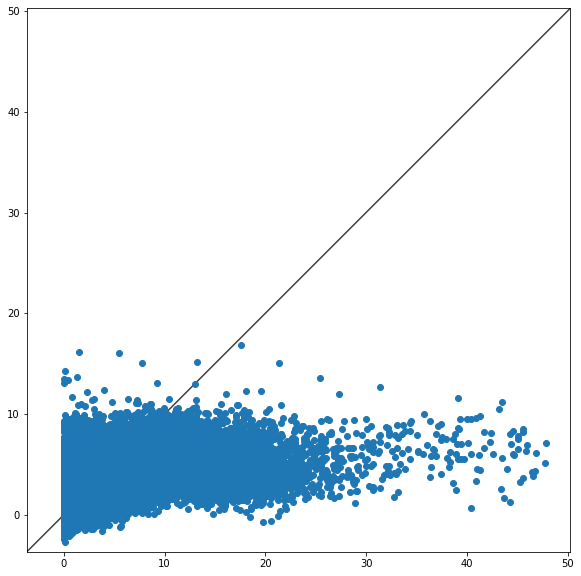

In [56]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [67]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station', 'Time_Cos', 'Time_Sin']+weather_var[:7]

parameters = {
    'model__alpha': np.logspace(-3, -1, 5),
    'model__l1_ratio': [0.1,0.5,0.9,1]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5; 2/20] START model__alpha=0.001, model__l1_ratio=0.5....................
[CV 2/5; 1/20] START model__alpha=0.001, model__l1_ratio=0.1....................
[CV 5/5; 1/20] START model__alpha=0.001, model__l1_ratio=0.1....................
[CV 3/5; 1/20] START model__alpha=0.001, model__l1_ratio=0.1....................
[CV 1/5; 2/20] START model__alpha=0.001, model__l1_ratio=0.5....................
[CV 2/5; 2/20] START model__alpha=0.001, model__l1_ratio=0.5....................
[CV 4/5; 1/20] START model__alpha=0.001, model__l1_ratio=0.1....................
[CV 1/5; 1/20] START model__alpha=0.001, model__l1_ratio=0.1....................
[CV 5/5; 1/20] END model__alpha=0.001, model__l1_ratio=0.1;, score=(train=-17.245, test=-17.162) total time= 1.8min
[CV 4/5; 2/20] START model__alpha=0.001, model__l1_ratio=0.5....................
[CV 2/5; 1/20] END model__alpha=0.001, model__l1_ratio=0.1;, score=(train=-17.206, test=-17.3

/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.1160215130076, tolerance: 443.63229672985943
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 3/20] END model__alpha=0.001, model__l1_ratio=0.9;, score=(train=-17.228, test=-17.147) total time=11.1min
[CV 2/5; 9/20] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 2/5; 3/20] END model__alpha=0.001, model__l1_ratio=0.9;, score=(train=-17.182, test=-17.294) total time=11.1min
[CV 3/5; 9/20] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 1/5; 9/20] END model__alpha=0.01, model__l1_ratio=0.1;, score=(train=-18.045, test=-18.009) total time=  30.6s
[CV 4/5; 9/20] START model__alpha=0.01, model__l1_ratio=0.1.....................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.8946550320834, tolerance: 443.4714016701686
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.60025223949924, tolerance: 444.1112906725769
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 9/20] END model__alpha=0.01, model__l1_ratio=0.1;, score=(train=-18.021, test=-18.081) total time=  18.2s
[CV 5/5; 9/20] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 3/5; 3/20] END model__alpha=0.001, model__l1_ratio=0.9;, score=(train=-17.153, test=-17.434) total time=11.1min
[CV 1/5; 10/20] START model__alpha=0.01, model__l1_ratio=0.5....................
[CV 4/5; 3/20] END model__alpha=0.001, model__l1_ratio=0.9;, score=(train=-17.217, test=-17.190) total time=11.0min
[CV 2/5; 10/20] START model__alpha=0.01, model__l1_ratio=0.5....................
[CV 5/5; 7/20] END model__alpha=0.0031622776601683794, model__l1_ratio=0.9;, score=(train=-17.669, test=-17.553) total time= 2.5min
[CV 3/5; 10/20] START model__alpha=0.01, model__l1_ratio=0.5....................
[CV 4/5; 7/20] END model__alpha=0.0031622776601683794, model__l1_ratio=0.9;, score=(train=-17.657, test=-17.614) total time= 2.8min
[CV 4/5; 10/20] START model__alpha=0.01, model__l1_ratio=0.5.....

alpha = 0.001, l1-ratio: 1
R2 of training: 0.19008673478279436
R2 of test: 0.18963244654148126


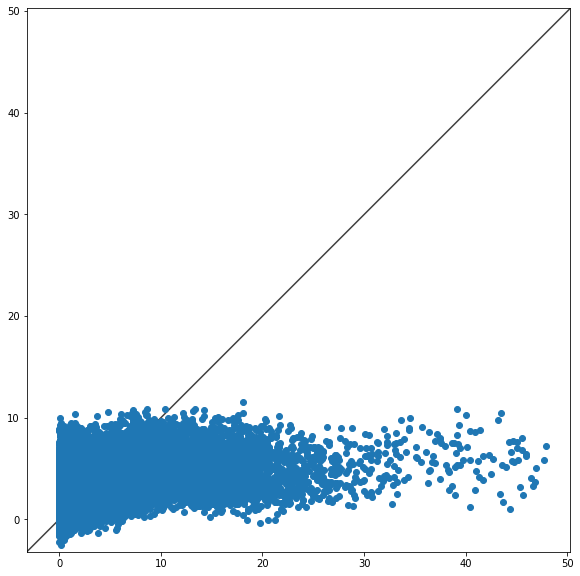

In [69]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [79]:
from sklearn.linear_model import ElasticNetCV
ENCV = ElasticNetCV(cv=5, alphas = np.logspace(-4, -1, 10), l1_ratio = [0.01,.1, .5, .7, .9, .99, 1], max_iter=10000)
ENCV.fit(X_train,y_train)
print(ENCV.alpha_,ENCV.l1_ratio_)

0.0001 0.1


R2 of training: 0.18958510882431823
R2 of test: 0.18282236725979728


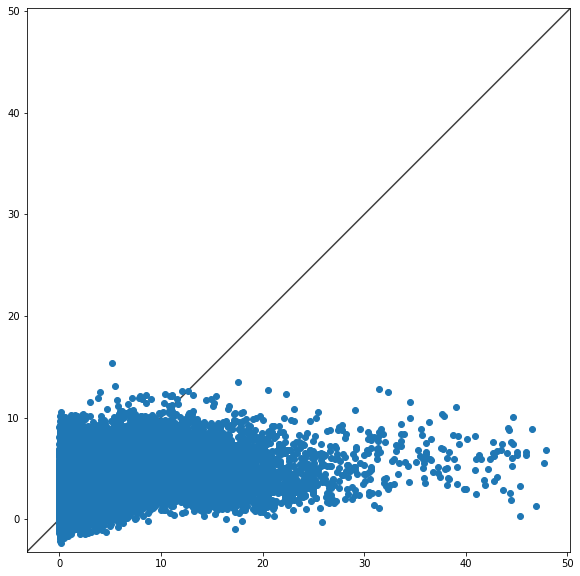

In [80]:
score_model(ENCV, X_train, X_test, y_train, y_test)

## Encode zones

In [81]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [82]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [83]:
Mean_Zone_Times = dict(pd.DataFrame({'Zone': X_train.filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y_train.values}).groupby('Zone').mean().squeeze())

X_train['Zone_E'] = X_train.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_test['Zone_E'] = X_test.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_train.drop(columns = X_train.filter(regex = 'lz'), inplace = True)
X_test.drop(columns =  X_test.filter(regex = 'lz'), inplace = True)

/var/folders/3z/pggbcw7949507j0lbw1gjngc0000gn/T/ipykernel_4363/1664792973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Zone_E'] = X_train.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
/var/folders/3z/pggbcw7949507j0lbw1gjngc0000gn/T/ipykernel_4363/1664792973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Zone_E'] = X_test.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWa

In [84]:
LM_model = LinearRegression(fit_intercept = False)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E', 'Time_Cos', 'Time_Sin']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ......, score=(train=-17.342, test=-17.032) total time=   0.4s
[CV 1/5; 1/1] END ......, score=(train=-17.261, test=-17.354) total time=   0.4s
[CV 3/5; 1/1] END ......, score=(train=-17.274, test=-17.301) total time=   0.4s
[CV 4/5; 1/1] END ......, score=(train=-17.231, test=-17.473) total time=   0.4s
[CV 2/5; 1/1] END ......, score=(train=-17.287, test=-17.250) total time=   0.4s


R2 of training: 0.18876157444669883
R2 of test: 0.18644628085112713


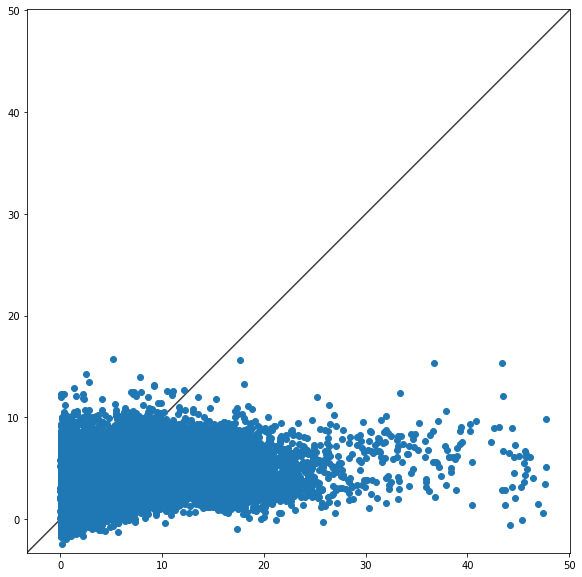

In [85]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [86]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E', 'Time_Cos', 'Time_Sin']+weather_var[:7]

parameters = {
    'model__alpha': np.logspace(-3, -1, 5),
    'model__l1_ratio': [0.001,0.01,0.1]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 2/5; 1/15] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 3/5; 1/15] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 4/5; 1/15] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 5/5; 1/15] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 3/5; 2/15] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 1/5; 1/15] START model__alpha=0.001, model__l1_ratio=0.001..................
[CV 1/5; 2/15] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 2/5; 2/15] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 3/5; 2/15] END model__alpha=0.001, model__l1_ratio=0.01;, score=(train=-17.274, test=-17.302) total time=  33.2s
[CV 4/5; 2/15] START model__alpha=0.001, model__l1_ratio=0.01...................
[CV 1/5; 2/15] END model__alpha=0.001, model__l1_ratio=0.01;, score=(train=-17.261, test=-17.

alpha = 0.001, l1-ratio: 0.001
R2 of training: 0.18876052874776839
R2 of test: 0.18646259009239108


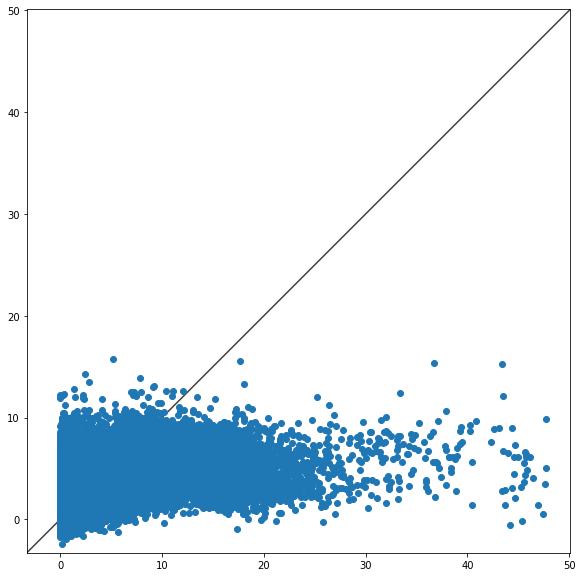

In [87]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [315]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E', 'Time_Cos', 'Time_Sin']+weather_var[:7]

parameters = {
    'model__n_neighbors': [50,100]
    #'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 2/5; 2/2] START model__n_neighbors=100......................................[CV 2/5; 1/2] START model__n_neighbors=50.......................................

[CV 4/5; 1/2] START model__n_neighbors=50.......................................
[CV 5/5; 1/2] START model__n_neighbors=50.......................................[CV 1/5; 2/2] START model__n_neighbors=100......................................

[CV 3/5; 2/2] START model__n_neighbors=100......................................
[CV 1/5; 1/2] START model__n_neighbors=50.......................................
[CV 3/5; 1/2] START model__n_neighbors=50.......................................
[CV 5/5; 1/2] END model__n_neighbors=50;, score=(train=-2.124, test=-2.183) total time=39.5min
[CV 4/5; 2/2] START model__n_neighbors=100......................................
[CV 2/5; 1/2] END model__n_neighbors=50;, score=(train=-2.116, test=-2.226) total time=42.3min
[CV 5/5; 2/2] START m

n_neighbors = 50
R2 of training: 0.26163497293070903
R2 of test: 0.23315724071293142


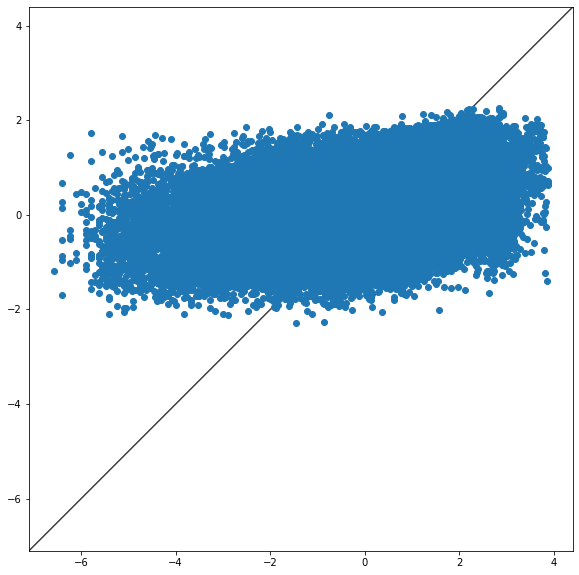

In [316]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]
 
print(f'n_neighbors = {n_neighbors}'), f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)